# Question 2

## Outline
* In this question, we examime the accuary and convernce speed of finite diference method (FDM) for ordinal differential equations (ODE) with boundary condition speed numerically.
* Especially, we consider the following ODE of second order with boundary condition:
$$
  \frac{d^2 y}{dx^2} + P(x) \frac{dy}{dx} + Q(x)y = f(x), \\
  y(a) = \alpha, y(b) = \beta.
$$
* An outline of finite difference method is as follows:
  1. discritize ODE to difference equation
  1. rewrite difference equation to matrix inversion problem
  1. After all solve this matrix numerically.
* As an algolithm for 3., we use "TriDiagonal Matrix Algorithm (TDMA)". For details of TDMA, see [P] for example. 

## Algorithm of FDM

### From ODE to diffrerence eqauation
* We discretize the inteval $[a, b]$ as $a = x_0 < x_1 < \cdots < x_{n-1} < x_n = b$, where $ x_i = a + i \delta x$, where $i = 0, 1, 2, \cdots, n$ and
$h = \delta x = \frac{b-a}{n}$.
* Let
$$
  y_i = y(x_i), P_i = P(x_i), Q_i = Q(x_i), f_i = f(x_i).
$$
* Associated to this discretization, we approximate differentials of each order as follows:
$$
  \frac{dy}{dx}(x_i) \approx \frac{y_{i+1} - y_{i-1}}{2\delta x}, \\
  \frac{d^2y}{dx^2}(x_i) \approx \frac{\frac{y_{i+1} - y_i}{\delta x} - \frac{y_{i} - y_{i-1}}{\delta x}}{\delta x} = \frac{y_{i+1} -2 y_i + y_{i-1}}{\delta x^2}.
$$
* Then our ODE is approximated as follows:
$$
  \frac{y_{i+1} -2 y_i + y_{i-1}}{\delta x^2} + P_i \frac{y_{i+1} - y_{i-1}}{2\delta x} + Q_i y_i = f_i.
$$
* We can rewrite this to
$$
  \bigg( 1 + \frac{\delta x}{2} P_i \bigg) y_{i+1} + \bigg(-2 + \delta x^2 Q_i \bigg)
  + \bigg( 1 - \frac{\delta x}{2} P_i \bigg) y_{i-1} = \delta x^2 f_i
$$
where $i = 1, 2, \cdots, n-1$.
* The boundary condition is rerwrited as 
$$
  y_0 = y(x_0) = y(a) = \alpha, \\
  y_n = y(x_n) = y(b) = \beta.
$$
* This finishes our discritization process.

### From differece equation to matrix inversion problem
* We can express our difference equation as the form $Ay = b$, where
$$\begin{align*}
  y &= (y_0, y_1, y_2, \cdots, y_n)^T, \\
  b &= (\alpha, \delta x^2 f_1, \delta x^2 f_2, \cdots, \delta x^2 f_{n-1}, \beta), \\
  A &= \begin{pmatrix}
    1 & 0 & 0 & 0 & \cdots & 0 & 0 & 0 \\
    1 - \frac{\delta x }{2} P_1 & -2 + \delta x^2 Q_1 & 1 + \frac{\delta x}{2} P_1 & 0 & \cdots & 0 & 0 & 0\\
    0 &  1 - \frac{\delta x}{2}P_2 & -2 + \delta x^2 Q_2 & 1 + \frac{\delta x}{2} P_2 & \cdots & 0 & 0 & 0\\
    \vdots & \ddots & \ddots & \ddots & \ddots & \vdots & \vdots & \vdots\\
    0 & 0 & 0 & 0 & \cdots & 1 - \frac{\delta x }{2} P_{n-1} & -2 + \delta x^2 Q_{n-1} & 1 + \frac{\delta x }{2} P_{n-1}\\
    0 & 0 & 0 & 0 & \cdots & 0 & 0 & 1
    \end{pmatrix}, \\
  \end{align*}
$$

## Numerical example

### Model setting
* For a numerical example, we consider the problem
$$
  \begin{align*}
    &\frac{d^2 y}{dx^2} + 3 \frac{dy}{dx} + 2y = 4x^2, \\
    &y(1) = 1, y(2) = 6.
  \end{align*}
$$

### Analytical solution
* In this case, we can solve this analytically.
* We assume a special solution of form $y = ax^2 + bx + c$.
* By direct calcuation, the case of $a=2, b=-6, c=7$ is a solution, that is,
  $y = 2 x^2 - 6 x + 7$ is a solution. Write this solution by $g$.

* The solution of homogeneous ODE $\frac{d^2 y}{dx^2} + 3 \frac{dy}{dx} + 2y = 0$ is
$y = A \exp(-x) + B \exp(-2x)$.
* Hence, the general solution of ODE is
$$
  y = A \exp(-x) + B \exp(-2x) + g(x).
$$
* We have two equation for $A, B$ as the boundary condition:
$$
  A e^{-1} + B e^{-2} = 1 - g(1) = -2, \\
  A e^{-2} + B e^{-4} = 6 - g(2) = 3.
$$
* $\begin{pmatrix} e^{-1} & e^{-2} \\ e^{-2} & e^{-4} \end{pmatrix}$ is regular, so we can solve this linear system. This gives the analytical solution for our boundary condition ploblem.

In [1]:
import numpy as np
from scipy.linalg import solve_banded
import matplotlib.pyplot as plt

## Implementation of the FDM solver

In [16]:
class Solver:
    def __init__(self, x_0, x_n, y_0, y_n, c_1, c_2, f):
        self.x_0 = x_0
        self.x_n = x_n
        self.y_0 = y_0
        self.y_n = y_n
        self.c_1 = c_1
        self.c_2 = c_2
        self.f = f

    def solve(self, n_grid):
        d = (self.x_n - self.x_0) / n_grid
        self.d = d 
        xs = np.linspace(self.x_0, self.x_n, n_grid+1)
        self.xs = xs 
        c_1_vec = self.c_1(xs[1:-1])
        c_2_vec = self.c_2(xs[1:-1])
        f_vec = self.f(xs[1:-1])
        
        a_banded = np.array([
            np.concatenate([[0, 0], 1.0 + d * c_1_vec / 2.0]),
            np.concatenate([[1.], -2.0 + d * d * c_2_vec, [1.]]),
            np.concatenate([1.0 - d * c_1_vec / 2.0, [0, 0]]),
        ])
        b = np.concatenate(
            [[self.y_0], d * d * f_vec, [self.y_n]]
        )

        return xs, solve_banded((1, 1), a_banded, b)        

## Numerical experience

### boundary condition

In [ ]:
x_0 = 1.0
x_n = 2.0

y_0 = 1.0
y_n = 6.0

### model setting
* we need to implement coefficient functions $P$, $Q$, and target function $f$ such that broadcasting is applied to the funtions automatically.
* if constant case, we need to use ```np.broadcast_to```, to clarify that the output is ```np.array``` with constant elements

In [22]:
c_1 = lambda xs: np.broadcast_to(3., xs.shape)
c_2 = lambda xs: np.broadcast_to(2., xs.shape)

f = lambda x: 4 * x * x

### implementation of analytical solution

In [9]:
boundary_mat = np.array([
    [np.exp(-x_0), np.exp(-2 * x_0)],
    [np.exp(-x_n), np.exp(-2 * x_n)]
    ])

In [30]:
special_sol = lambda x: 2 * x * x - 6 * x + 7
y_sp_0 = special_sol(x_0)
y_sp_n = special_sol(x_n)

In [31]:
boundary_coeff = np.linalg.inv(boundary_mat) @ np.array([y_0 - y_sp_0 , y_n - y_sp_n])

In [32]:
y_an = lambda x: boundary_coeff[0] * np.exp(-x) + boundary_coeff[1] * np.exp(-2 * x) + special_sol(x)

## Result: FDM calculation and comparison with the analytical solution

In [35]:
solver = Solver(x_0, x_n, y_0, y_n, c_1, c_2, f)
n_grids = [10, 50, 100]

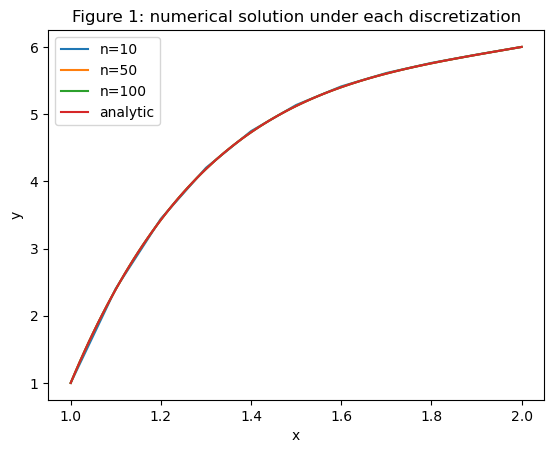

In [51]:
for n in n_grids:
    xs, ys = solver.solve(n)
    plt.plot(xs, ys, label=f'n={n}')

plt.plot(xs, y_an(xs), label='analytic')

plt.legend()
plt.title('Figure 1: numerical solution under each discretization')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

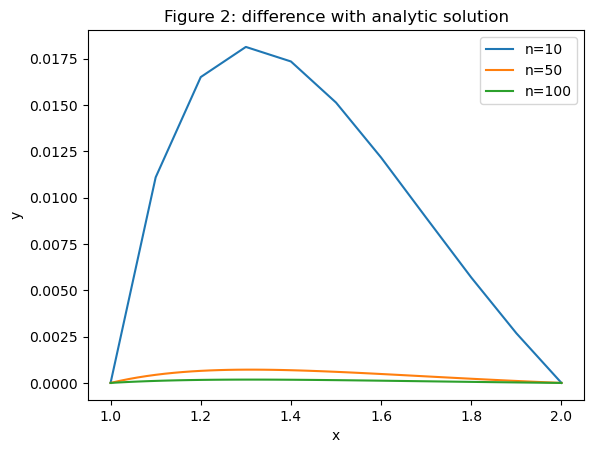

In [52]:
diff_max = {}
for n in n_grids:
    xs, ys = solver.solve(n)
    plt.plot(xs, ys - y_an(xs), label=f'n={n}')
    diff_max[n] = np.max(ys - y_an(xs))

plt.legend()
plt.title('Figure 2: difference with analytic solution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

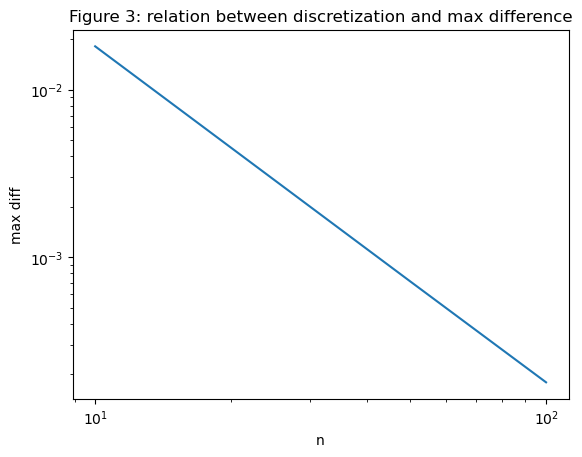

In [53]:
plt.plot(diff_max.keys(), diff_max.values())
plt.yscale('log')
plt.xscale('log')
plt.title('Figure 3: relation between discretization and max difference')
plt.xlabel('n')
plt.ylabel('max diff')
plt.show()

## Observation
* Our FDM method gives sufficently accurate solution (Figure 1).
* We can confirm that the finer discretization of the interval gives more accuate numerical solution (Figure 2).
* In addition, this relation is estimated second order, that is max diff = constant x discretzation number^-2 (Figure 3).

## Conclusion
* For our boundary condistion problem in this question, FDM method is well-worked from the point of view with accuracy.
* This implemantation can handle various form of $P$, $Q$, $f$ flexibly: only need to implementation each function as python function object.
* Note that it is more difficult to solve more higher order problem, because the matrix form is more complecated. Especially we need calculation cost for Step (3).  

## Reference
[P]: Patankar, S. (1980). Numerical Heat Transfer and Fluid Flow (1st ed.). CRC Press. https://doi.org/10.1201/9781482234213

End.